In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Veri yolları
base_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360'  # Verisetinizin ana dizinini buraya yazın
train_dir = os.path.join(base_dir, 'Training')

# Görüntü boyutu ve batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator ile verileri yükleme
datagen = ImageDataGenerator(rescale=1./255)

# Tüm veri ve etiketleri okuma
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Etiketlerin sırasını korumak için shuffle=False
)

# Veri ve etiketleri toplama
file_paths = train_generator.filepaths
labels = train_generator.classes
class_indices = train_generator.class_indices  # Sınıf isimleri ve etiket eşleştirmesi
num_classes = len(class_indices)

# Stratify kullanarak eğitim ve doğrulama setini ayırma
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Custom DataGenerator
def custom_data_generator(file_paths, labels, batch_size, target_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            batch_images = []
            for path in batch_paths:
                img = load_img(path, target_size=target_size)  # Görüntüyü yükle
                img_array = img_to_array(img) / 255.0  # Ölçekle
                batch_images.append(img_array)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes=num_classes)

# Eğitim ve doğrulama generator'ları
train_gen = custom_data_generator(train_paths, train_labels, batch_size, img_size)
val_gen = custom_data_generator(val_paths, val_labels, batch_size, img_size)

# ResNet50 modelini yükleme
resnet50_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# ResNet50 katmanlarını dondurma
for layer in resnet50_model.layers:
    layer.trainable = False

# Modeli oluşturma
model = Sequential()
model.add(resnet50_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Modeli derleme
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Eğitim
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=30
)

# Eğitim tamamlandıktan sonra
print("ResNet50 ile Özellik Çıkarımı ve Eğitim Tamamlandı.")


Found 70491 images belonging to 141 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 446s 245ms/step - accuracy: 0.0529 - loss: 4.7549 - val_accuracy: 0.1805 - val_loss: 4.1183
Epoch 2/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 201s 112ms/step - accuracy: 0.2081 - loss: 3.9264 - val_accuracy: 0.3574 - val_loss: 3.3941
Epoch 3/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.3693 - loss: 3.2492 - val_accuracy: 0.4581 - val_loss: 2.8737
Epoch 4/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.5451 - loss: 2.4108 - val_accuracy: 0.5899 - val_loss: 2.1978
Epoch 6/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.6527 - loss: 1.9070 - val_accuracy: 0.6851 - val_loss: 1.7658
Epoch 8/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.6900 - loss: 1.7205 - val_accuracy: 0.7185 - val_loss: 1.6009
Epoch 9/30
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.7222 - loss: 1.5589 - val_ac

In [ ]:
# ResNet50 Fine-Tuning
print("ResNet50 Fine-Tuning Başlıyor...")

# ResNet50'nin son katmanlarını eğitilebilir hale getir
resnet50_model.trainable = True

# İlk birkaç katmanı dondur (örneğin, ilk 140 katman)
for layer in resnet50_model.layers[:140]:
    layer.trainable = False

# Modeli yeniden derle
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Daha düşük bir öğrenme oranı kullanılır
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning eğitimi
fine_tune_history = model.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=10  # Daha az epoch kullanılır
)

# Fine-tuning tamamlandıktan sonra
print("ResNet50 Fine-Tuning Tamamlandı.")


ResNet50 Fine-Tuning Başlıyor...
Epoch 1/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 207s 113ms/step - accuracy: 0.9514 - loss: 0.3513 - val_accuracy: 0.9527 - val_loss: 0.3467
Epoch 2/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9551 - loss: 0.3323 - val_accuracy: 0.9551 - val_loss: 0.3295
Epoch 3/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9583 - loss: 0.3152 - val_accuracy: 0.9576 - val_loss: 0.3133
Epoch 4/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9611 - loss: 0.2989 - val_accuracy: 0.9595 - val_loss: 0.2979
Epoch 5/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9636 - loss: 0.2841 - val_accuracy: 0.9613 - val_loss: 0.2835
Epoch 6/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9661 - loss: 0.2704 - val_accuracy: 0.9640 - val_loss: 0.2696
Epoch 7/10
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 199s 113ms/step - accuracy: 0.9687 - loss: 0.2574 - val_accuracy: 0.9664 - val_loss: 0.2568
Epoch 8/10
1762/1762 ━━━━━━━━

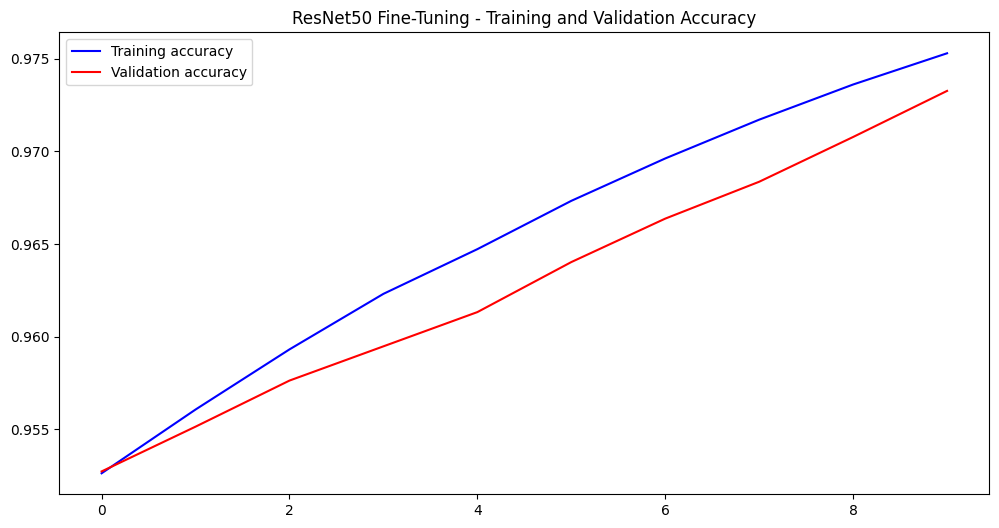

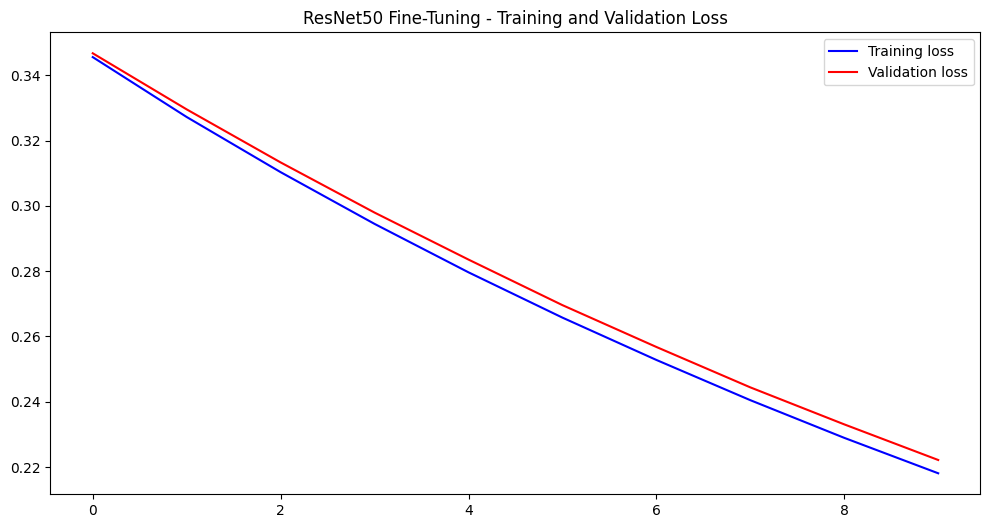

In [ ]:
import matplotlib.pyplot as plt

def plot_fine_tuning(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'{model_name} Fine-Tuning - Training and Validation Accuracy')
    plt.legend()

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} Fine-Tuning - Training and Validation Loss')
    plt.legend()

    plt.show()

# Fine-tuning sonuçlarını görselleştir
plot_fine_tuning(fine_tune_history, "ResNet50")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np


test_dir = os.path.join(base_dir, 'Test')

# Test veri generator'ını oluşturma
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test verisinin sırası korunmalı
)

# Test setinde tahminler
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)  # En yüksek olasılığa sahip sınıf
true_classes = test_generator.classes  # Gerçek sınıflar

# Accuracy, F1-score, Precision, Recall
accuracy = accuracy_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Genel metrikleri yazdır
print("Model Performans Değerleri:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Sınıf bazında performans raporu
print("\nSınıf Bazında Performans Raporu:")
class_labels = list(test_generator.class_indices.keys())  # Sınıf isimleri
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Found 23619 images belonging to 141 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 119s 157ms/step
Model Performans Değerleri:
Accuracy: 0.8482
F1 Score: 0.8427
Precision: 0.8589
Recall: 0.8482

Sınıf Bazında Performans Raporu:
                       precision    recall  f1-score   support

              Apple 6       0.55      1.00      0.71       157
     Apple Braeburn 1       0.82      0.76      0.79       164
 Apple Crimson Snow 1       0.82      0.97      0.89       148
       Apple Golden 1       0.94      0.75      0.83       160
       Apple Golden 2       0.95      0.90      0.93       164
       Apple Golden 3       0.90      0.90      0.90       161
 Apple Granny Smith 1       0.96      0.96      0.96       164
    Apple Pink Lady 1       0.60      0.82      0.69       152
          Apple Red 1       0.89      0.84      0.87       164
          Apple Red 2       1.00      0.98      0.99       164
          Apple Red 3       0.94      0.93      0.93       144
Apple Red Delicious 1       0.82      0.78      0.80       166
   App

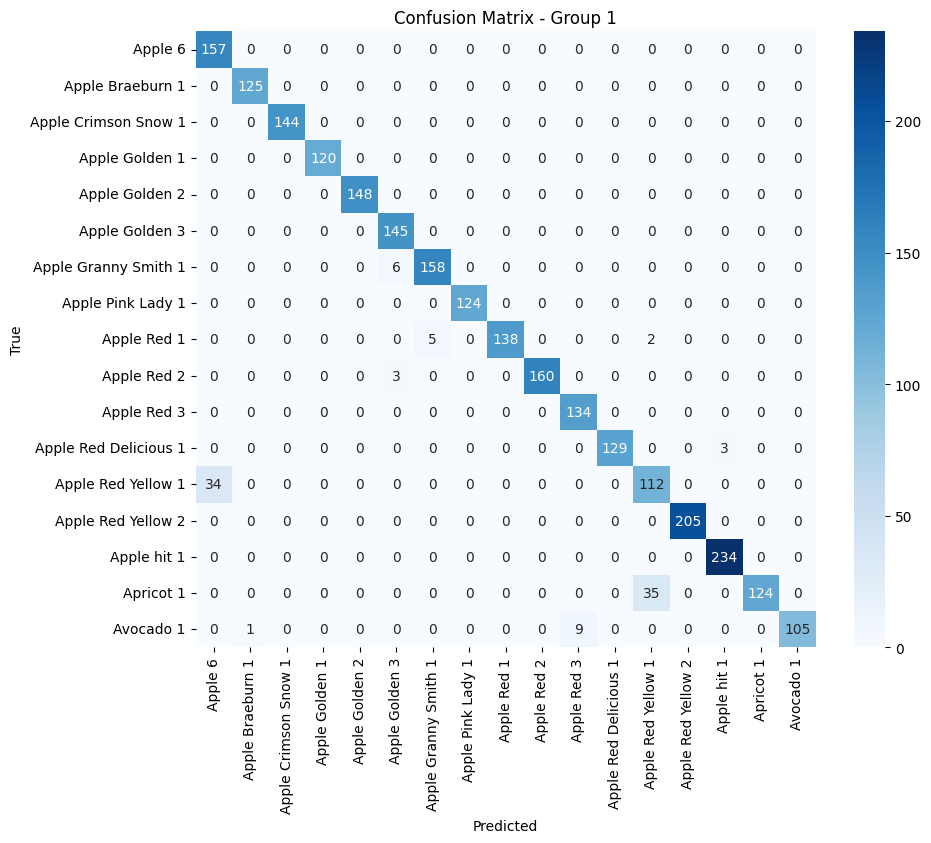

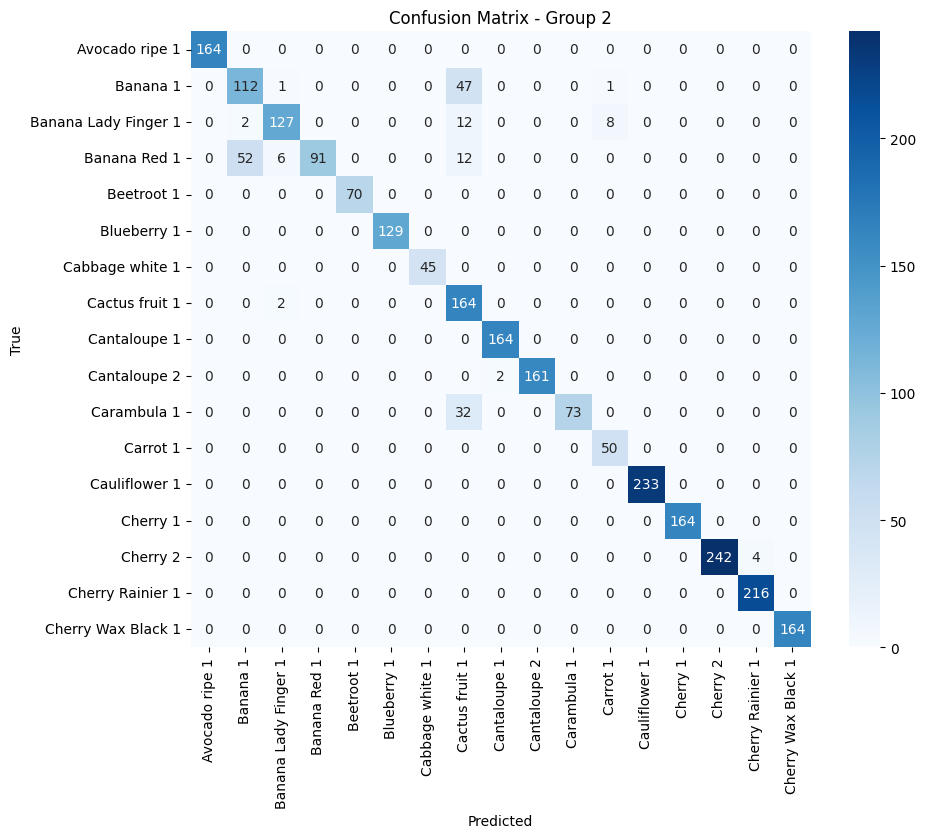

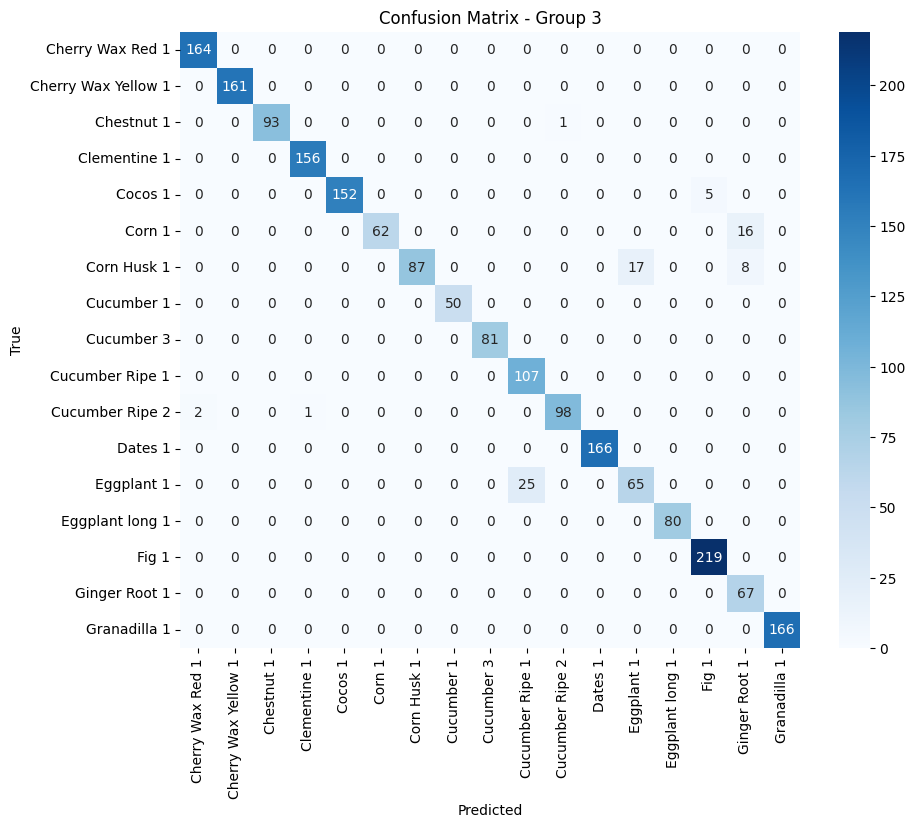

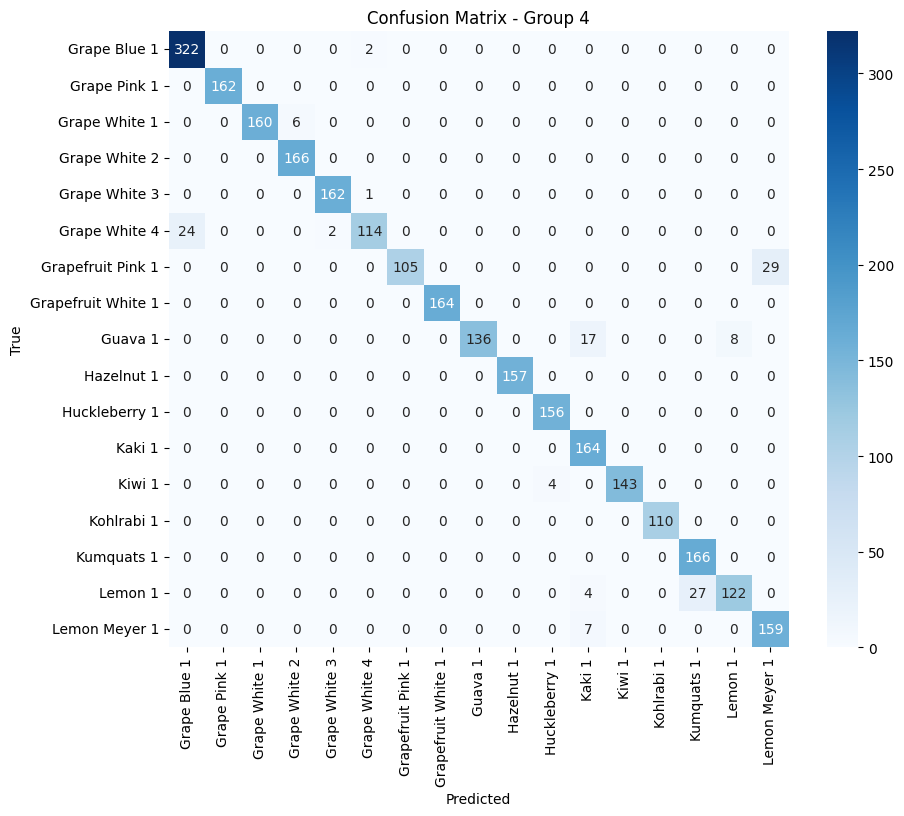

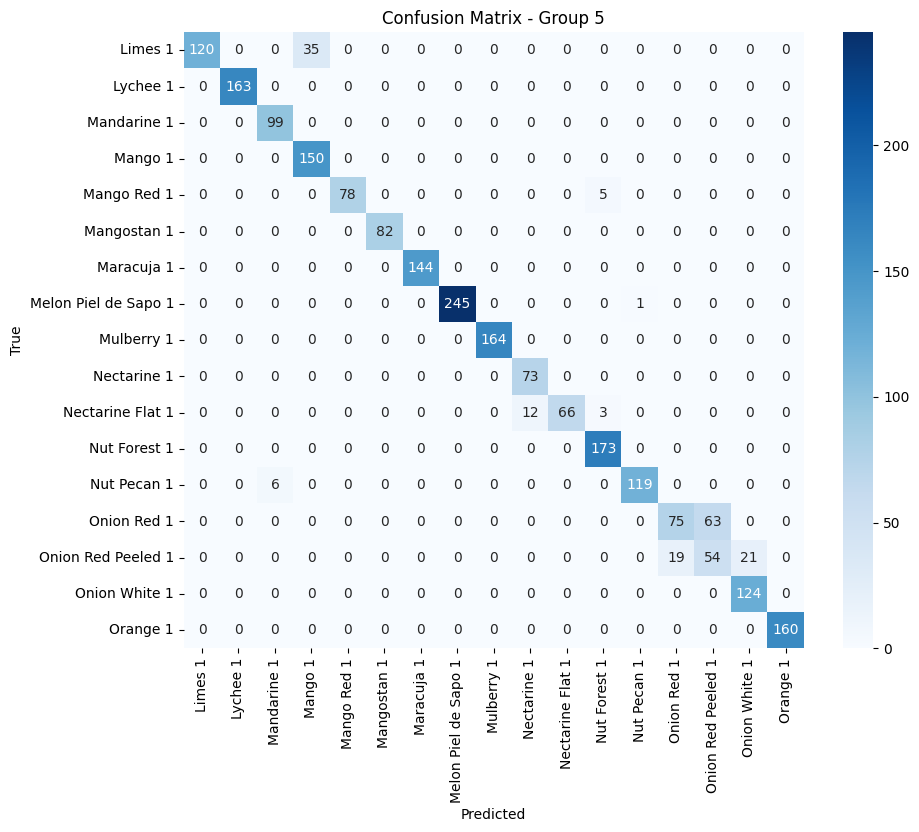

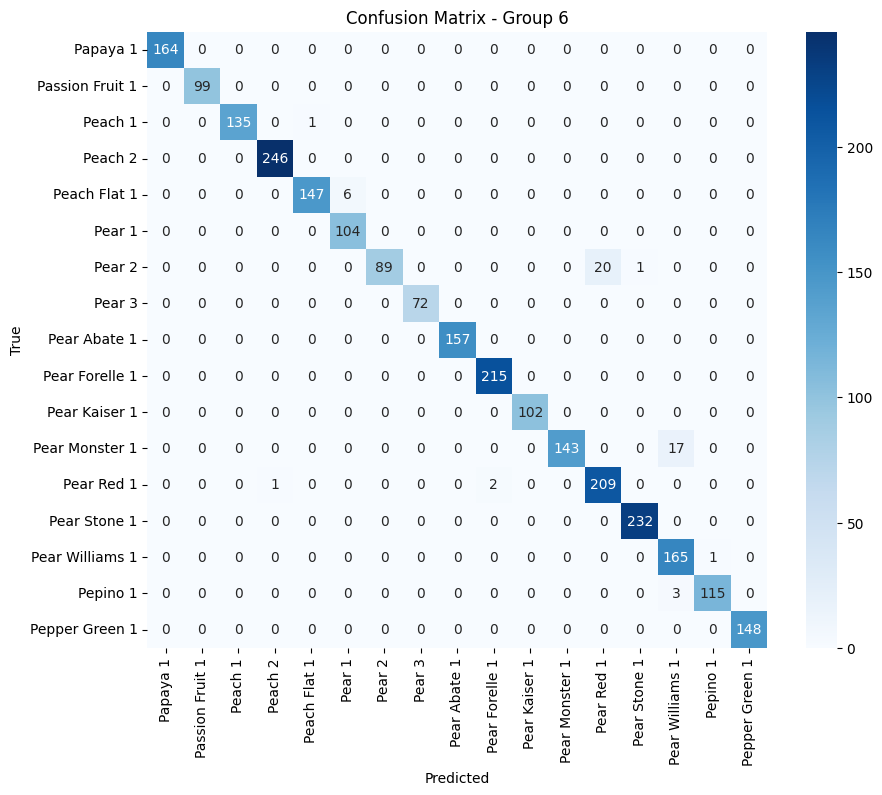

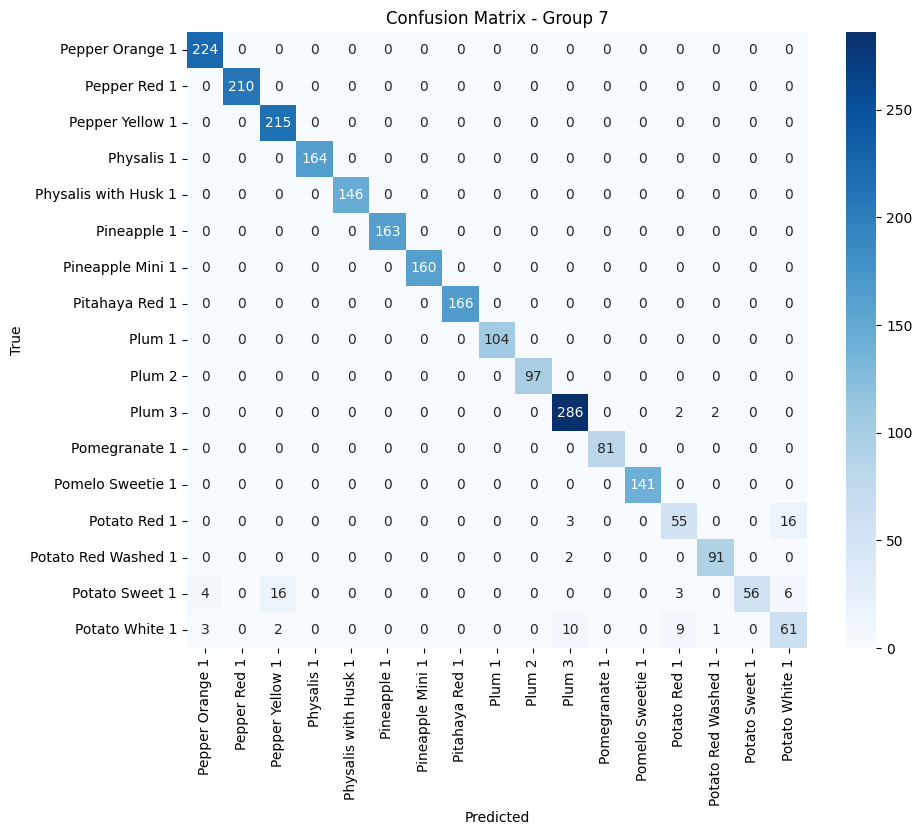

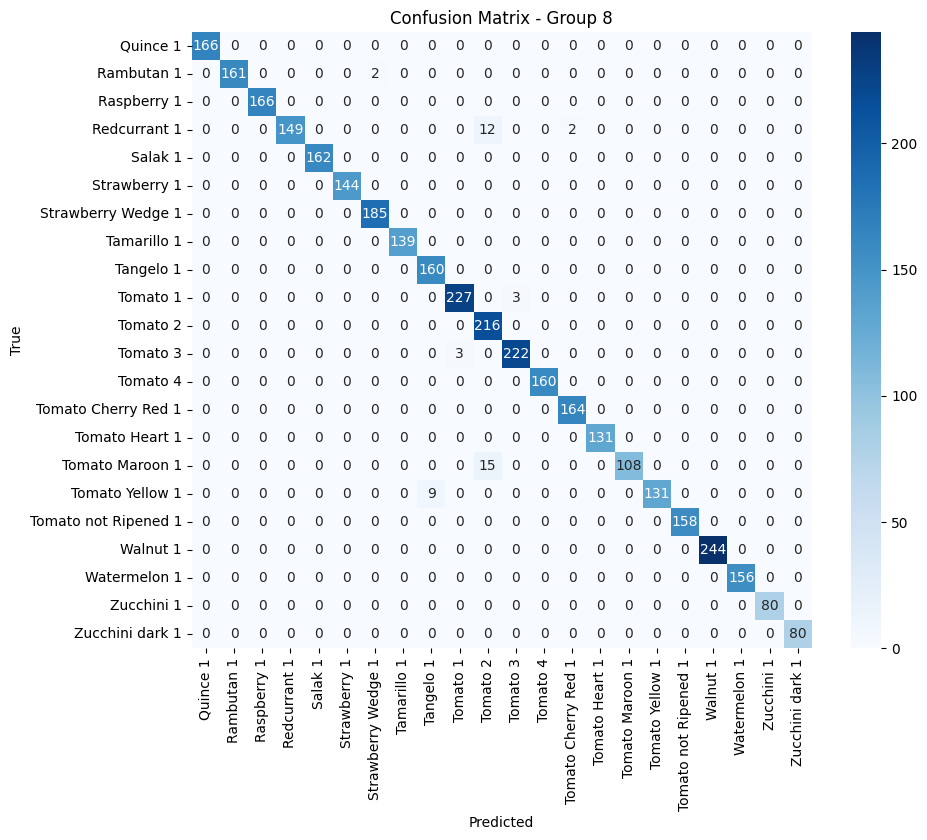

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sınıfları 8 parçaya bölme
num_classes = len(class_labels)  # Toplam sınıf sayısı
num_groups = 8  # Kaç parçaya bölmek istediğimiz
group_size = num_classes // num_groups  # Her grubun boyutu
groups = [class_labels[i * group_size:(i + 1) * group_size] for i in range(num_groups)]

# Eğer sınıflar eşit bölünemiyorsa son gruba kalan sınıfları ekle
if num_classes % num_groups != 0:
    groups[-1].extend(class_labels[num_groups * group_size:])

# Her grup için karışıklık matrisini çizdirme
for i, group_labels in enumerate(groups):
    # Grubun indekslerini bulma
    indices = [class_labels.index(label) for label in group_labels]

    # Grubun karışıklık matrisini oluşturma
    group_conf_matrix = conf_matrix[indices][:, indices]

    # Matrisi çizdirme
    plt.figure(figsize=(10, 8))
    sns.heatmap(group_conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=group_labels, yticklabels=group_labels)
    plt.title(f"Confusion Matrix - Group {i + 1}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [ ]:
import torch

# Modeli tam haliyle kaydet
torch.save(model, "resnet50_fine_tuned_model.pth")


In [ ]:
import os
import numpy as np
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
# Veri yolları
base_dir = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360'  # Verisetinizin ana dizinini buraya yazın
train_dir = os.path.join(base_dir, 'Training')

# Görüntü boyutu ve batch size
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator ile verileri yükleme
datagen = ImageDataGenerator(rescale=1./255)

# Tüm veri ve etiketleri okuma
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Etiketlerin sırasını korumak için shuffle=False
)

# Veri ve etiketleri toplama
file_paths = train_generator.filepaths
labels = train_generator.classes
class_indices = train_generator.class_indices  # Sınıf isimleri ve etiket eşleştirmesi
num_classes = len(class_indices)

# Stratify kullanarak eğitim ve doğrulama setini ayırma
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Custom DataGenerator
def custom_data_generator(file_paths, labels, batch_size, target_size):
    while True:
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            batch_images = []
            for path in batch_paths:
                img = load_img(path, target_size=target_size)  # Görüntüyü yükle
                img_array = img_to_array(img) / 255.0  # Ölçekle
                batch_images.append(img_array)

            yield np.array(batch_images), to_categorical(batch_labels, num_classes=num_classes)

# Eğitim ve doğrulama generator'ları
train_gen = custom_data_generator(train_paths, train_labels, batch_size, img_size)
val_gen = custom_data_generator(val_paths, val_labels, batch_size, img_size)


# MobileNet modelini oluşturma
mobilenet_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in mobilenet_model.layers:
    layer.trainable = False  # MobileNet katmanlarını dondur

mobilenet_classifier = Sequential([
    mobilenet_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout ekledik
    Dense(num_classes, activation='softmax')
])

mobilenet_classifier.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# MobileNet modelinin eğitimi
print("MobileNet Modeli Eğitiliyor...")
mobilenet_history = mobilenet_classifier.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=5
)


# Eğitim sonuçları

print("MobileNet Modeli Eğitim Tamamlandı.")


Found 70491 images belonging to 141 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNet Modeli Eğitiliyor...
Epoch 1/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 646s 361ms/step - accuracy: 0.0437 - loss: 5.3423 - val_accuracy: 0.4431 - val_loss: 3.1091
Epoch 2/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 243s 136ms/step - accuracy: 0.3132 - loss: 3.1497 - val_accuracy: 0.7889 - val_loss: 1.5256
Epoch 3/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 268s 152ms/step - accuracy: 0.5720 - loss: 1.8933 - val_accuracy: 0.9277 - val_loss: 0.7360
Epoch 4/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 176s 100ms/step - accuracy: 0.7348 - loss: 1.1714 - val_accuracy: 0.9738 - val_loss: 0.3615
Epoch 5/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 174s 99ms/step - accuracy: 0.8318 - loss: 0.7582 - val_accuracy: 0.9888 - val_loss: 0.1832
MobileNet Modeli Eğitim Tamamlandı.


In [ ]:
# MobileNet için Fine-Tuning
print("MobileNet Fine-Tuning Başlıyor...")

# MobileNet'in temel modelini eğitilebilir hale getir
mobilenet_model.trainable = True

# İlk birkaç katmanı dondur (örneğin, ilk 70 katman)
for layer in mobilenet_model.layers[:70]:
    layer.trainable = False

# Modeli yeniden derle
mobilenet_classifier.compile(
    optimizer=Adam(learning_rate=1e-6),  # Daha düşük öğrenme oranı
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning eğitimi
mobilenet_fine_tune_history = mobilenet_classifier.fit(
    train_gen,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_paths) // batch_size,
    epochs=5  # Daha az epoch kullanılır
)

print("MobileNet Fine-Tuning Tamamlandı.")

MobileNet Fine-Tuning Başlıyor...
Epoch 1/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 172s 95ms/step - accuracy: 0.8948 - loss: 0.4966 - val_accuracy: 0.9952 - val_loss: 0.0925
Epoch 2/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 178s 101ms/step - accuracy: 0.9371 - loss: 0.3272 - val_accuracy: 0.9980 - val_loss: 0.0507
Epoch 3/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 182s 103ms/step - accuracy: 0.9585 - loss: 0.2283 - val_accuracy: 0.9990 - val_loss: 0.0285
Epoch 4/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 169s 96ms/step - accuracy: 0.9701 - loss: 0.1680 - val_accuracy: 0.9995 - val_loss: 0.0176
Epoch 5/5
1762/1762 ━━━━━━━━━━━━━━━━━━━━ 147s 84ms/step - accuracy: 0.9794 - loss: 0.1232 - val_accuracy: 0.9998 - val_loss: 0.0111
MobileNet Fine-Tuning Tamamlandı.


In [ ]:
# Modeli kaydetme
mobilenet_model.save('mobilenet_fruit_classifier.h5')

print("Model başarıyla 'mobilenet_fruit_classifier.h5' olarak kaydedildi.")


Model başarıyla 'mobilenet_fruit_classifier.h5' olarak kaydedildi.



Training/Validation Loss and Accuracy (Initial Training):


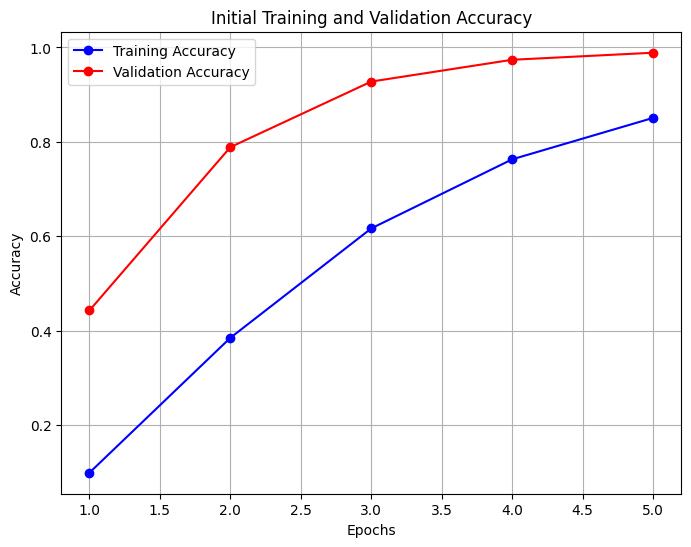

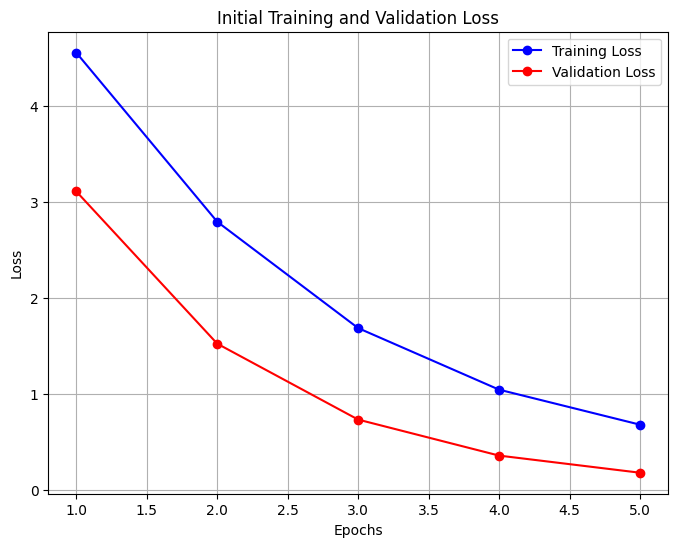


Training/Validation Loss and Accuracy (Fine-Tuning):


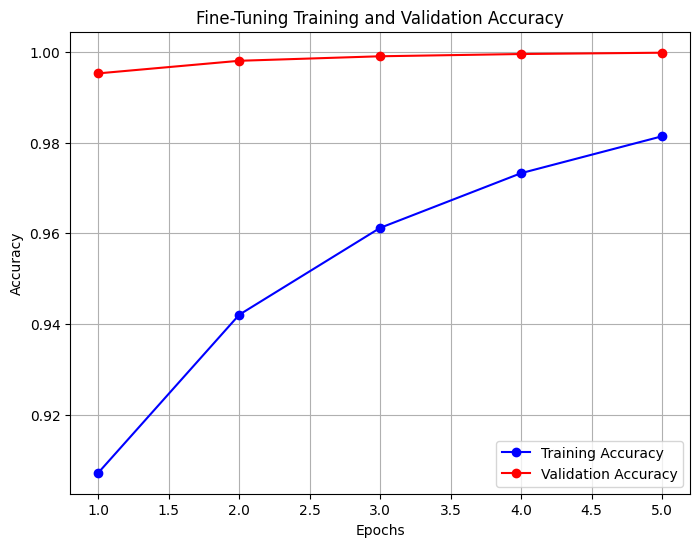

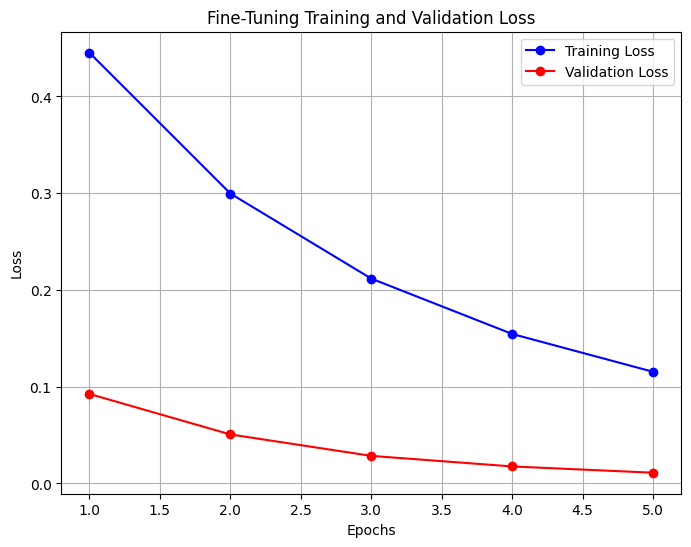

In [ ]:
import matplotlib.pyplot as plt

# Eğitim ve Doğrulama Loss/Accuracy Değerlerini Yazdırma
def plot_training_validation(history, title_prefix=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f"{title_prefix}Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Grafiği
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f"{title_prefix}Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Eğitim ve doğrulama metriklerini yazdırma
print("\nTraining/Validation Loss and Accuracy (Initial Training):")
plot_training_validation(mobilenet_history, title_prefix="Initial ")

print("\nTraining/Validation Loss and Accuracy (Fine-Tuning):")
plot_training_validation(mobilenet_fine_tune_history, title_prefix="Fine-Tuning ")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Test veri seti yolu
test_dir = os.path.join(base_dir, 'Test')  # Test verilerinin bulunduğu dizin

# Test veri generator'ı
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test verisinin sırası korunmalı
)

# Test setinde tahminler
print("MobileNet modeli test verisi üzerinde tahmin yapıyor...")
mobilenet_predictions = mobilenet_classifier.predict(test_generator, steps=len(test_generator), verbose=1)
mobilenet_predicted_classes = np.argmax(mobilenet_predictions, axis=1)  # Tahmin edilen sınıflar
mobilenet_true_classes = test_generator.classes  # Gerçek sınıflar

# Accuracy, F1-score, Precision, Recall (genel)
mobilenet_accuracy = accuracy_score(mobilenet_true_classes, mobilenet_predicted_classes)
mobilenet_f1 = f1_score(mobilenet_true_classes, mobilenet_predicted_classes, average='weighted')
mobilenet_precision = precision_score(mobilenet_true_classes, mobilenet_predicted_classes, average='weighted')
mobilenet_recall = recall_score(mobilenet_true_classes, mobilenet_predicted_classes, average='weighted')

# Genel metrikleri yazdır
print("\nMobileNet Performans Değerleri (Test Seti):")
print(f"Test Seti Accuracy: {mobilenet_accuracy:.4f}")
print(f"F1 Score: {mobilenet_f1:.4f}")
print(f"Precision: {mobilenet_precision:.4f}")
print(f"Recall: {mobilenet_recall:.4f}")

# Sınıf Bazında Performans Raporu
print("\nMobileNet Sınıf Bazında Performans Raporu (Test Seti):")
class_labels = list(test_generator.class_indices.keys())  # Sınıf isimlerini al
print(classification_report(mobilenet_true_classes, mobilenet_predicted_classes, target_names=class_labels))


Found 23619 images belonging to 141 classes.
MobileNet modeli test verisi üzerinde tahmin yapıyor...


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 181s 243ms/step

MobileNet Performans Değerleri (Test Seti):
Test Seti Accuracy: 0.9420
F1 Score: 0.9405
Precision: 0.9481
Recall: 0.9420

MobileNet Sınıf Bazında Performans Raporu (Test Seti):
                       precision    recall  f1-score   support

              Apple 6       1.00      1.00      1.00       157
     Apple Braeburn 1       0.85      0.74      0.79       164
 Apple Crimson Snow 1       0.77      0.89      0.82       148
       Apple Golden 1       0.99      1.00      0.99       160
       Apple Golden 2       0.74      0.99      0.85       164
       Apple Golden 3       0.76      0.97      0.85       161
 Apple Granny Smith 1       1.00      0.65      0.79       164
    Apple Pink Lady 1       0.85      0.71      0.77       152
          Apple Red 1       0.91      0.87      0.89       164
          Apple Red 2       0.84      0.84      0.84       164
          Apple Red 3       0.96      0.99      0.98       144
Apple Red Delicious 

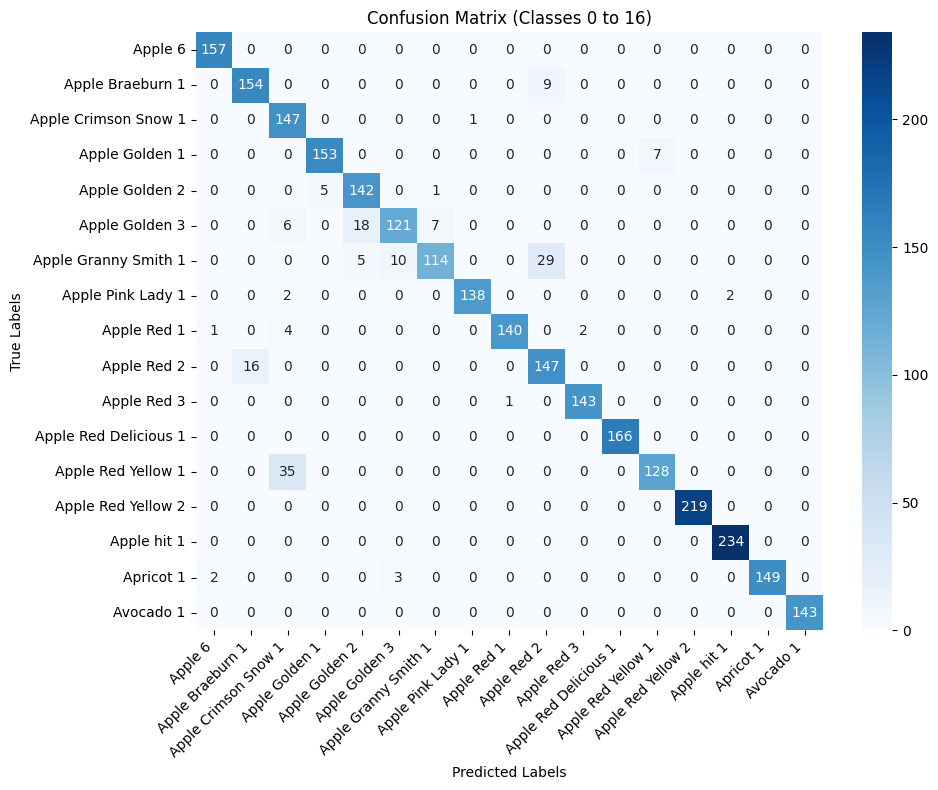

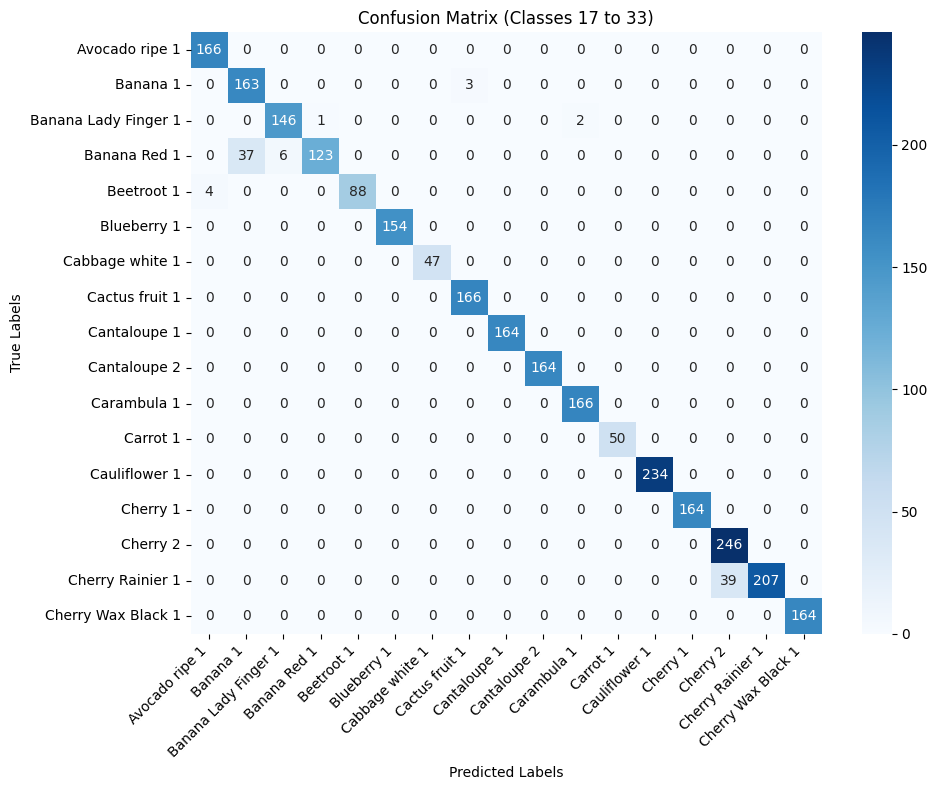

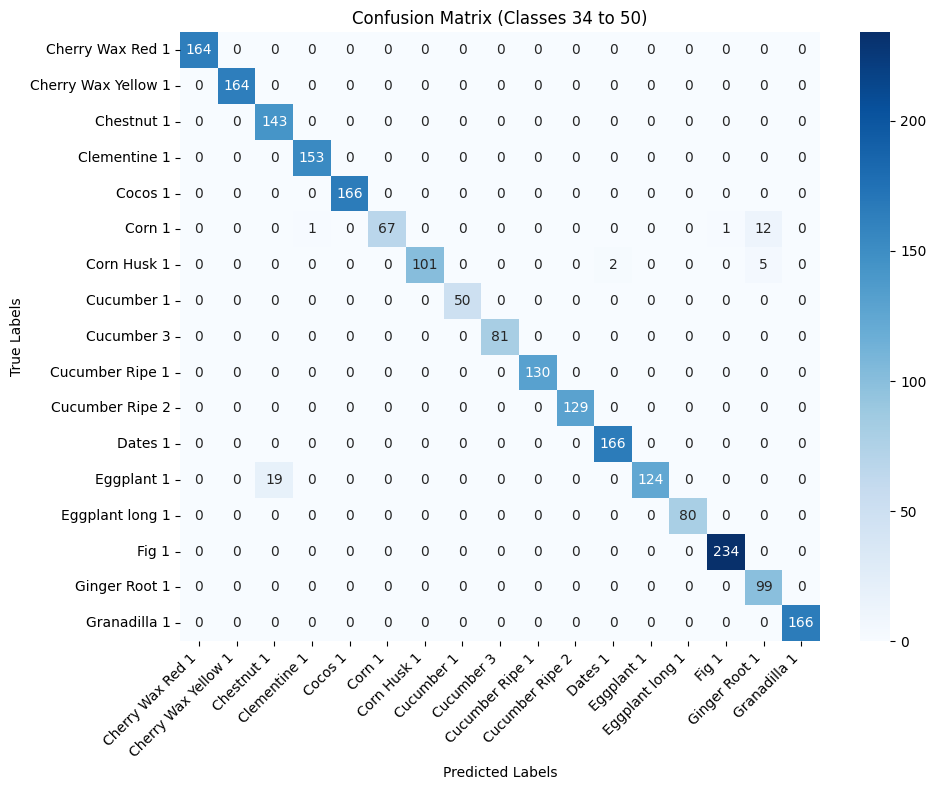

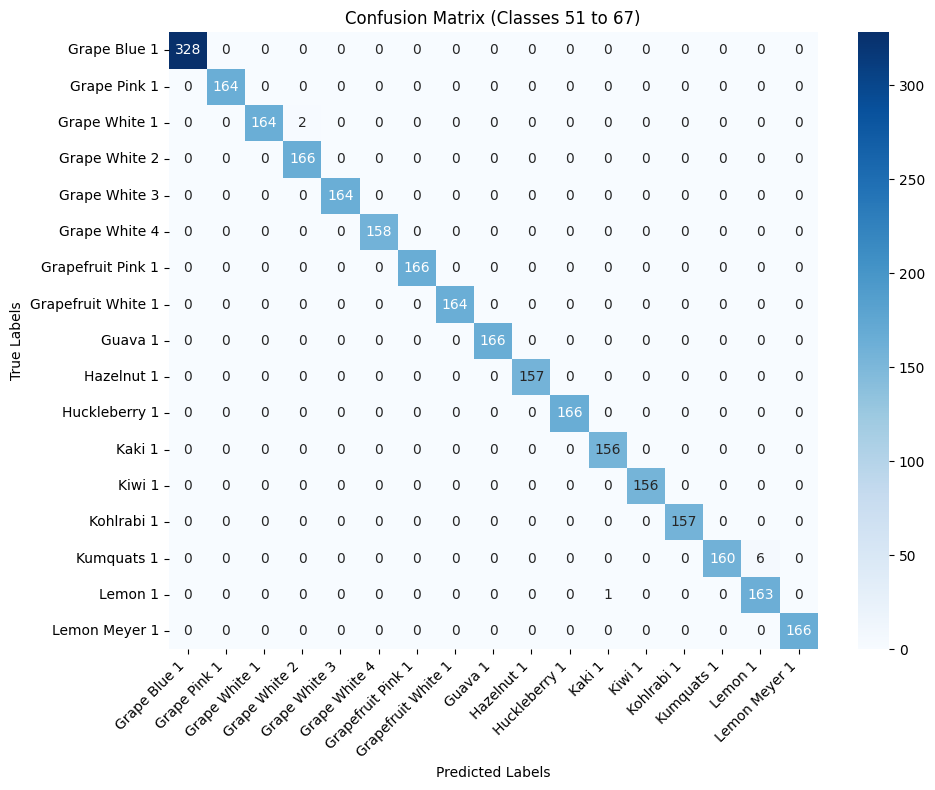

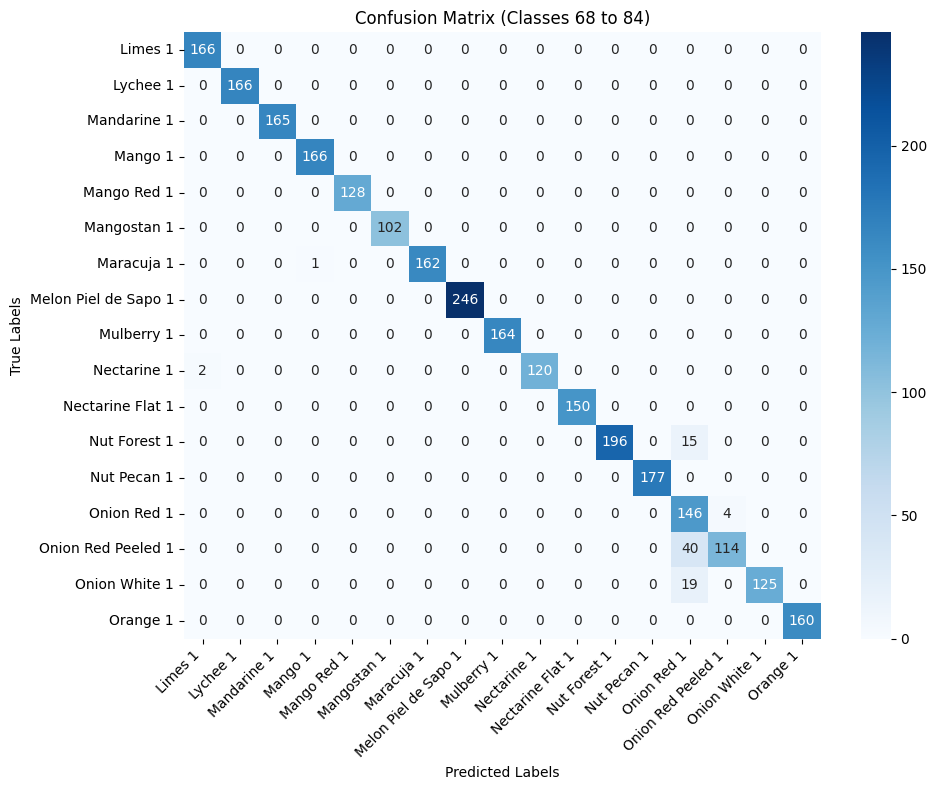

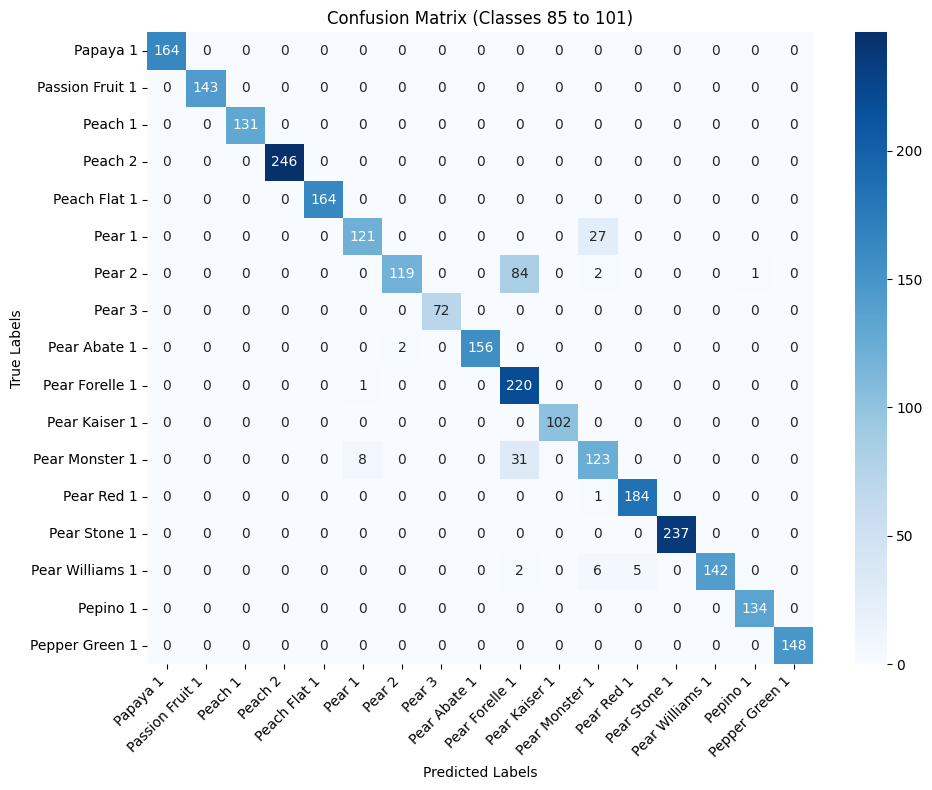

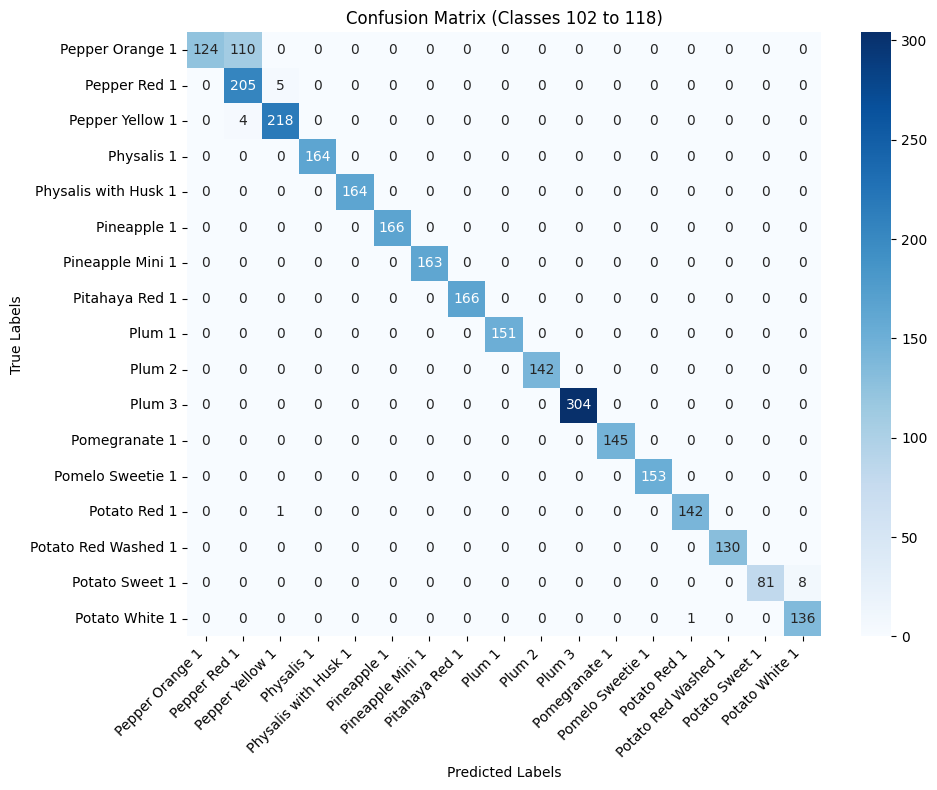

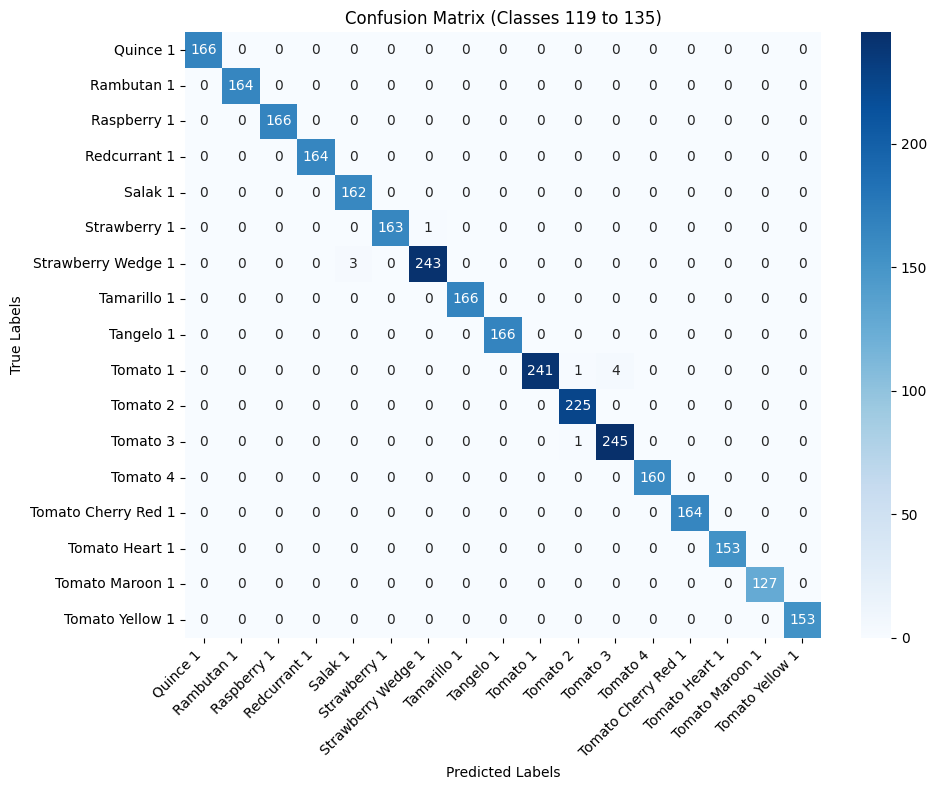

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Confusion Matrix oluşturma
conf_matrix = confusion_matrix(mobilenet_true_classes, mobilenet_predicted_classes)

# 141 sınıfı 8 gruba bölme
num_classes = len(class_labels)
split_size = num_classes // 8  # Her confusion matrix'te yer alacak sınıf sayısı
splits = [split_size * i for i in range(9)]  # Sınıfları bölmek için indeksler

# Confusion matrix'i bölüp görselleştirme
for i in range(len(splits) - 1):
    start, end = splits[i], splits[i + 1]  # Başlangıç ve bitiş indeksleri
    sub_conf_matrix = conf_matrix[start:end, start:end]  # Alt grup matrisini al

    # Alt grup sınıf isimlerini al
    sub_class_labels = class_labels[start:end]

    # Görselleştirme
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        sub_conf_matrix,
        annot=True,  # Sayısal değerleri göster
        fmt='d',  # Tamsayı formatında görüntüle
        cmap='Blues',
        xticklabels=sub_class_labels,
        yticklabels=sub_class_labels
    )
    plt.title(f'Confusion Matrix (Classes {start} to {end - 1})')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
